### Calculate deaths from PM2.5

In [2]:
import geopandas as gpd
import xarray as xr
from cartopy import crs as ccrs
import seaborn as sns; sns.set_theme()
import os
import fiona
import country_converter as coco
import dask
import dask.array as da
import netCDF4 as nc
import regionmask
from matplotlib import cm
import numpy as np
from matplotlib import pyplot as plt
import country_converter as coco
import pyogrio
#pyogrio.set_gdal_config_options({"SHAPE_RESTORE_SHX": "YES"})
import pandas as pd
from cartopy.util import add_cyclic_point
import nc_time_axis
import glob
import cdo
import pandas as pd
import cartopy.feature as cfeature


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Gridded Population of the World, Version 4 (GPWv4): National Identifier Grid, Revision 11
# can be downloaded from: https://www.earthdata.nasa.gov/data/catalog/sedac-ciesin-sedac-gpwv4-natiden-r11-4.11#:~:text=Description,use%20in%20aggregating%20population%20data.
# cited as: Center For International Earth Science Information Network-CIESIN-Columbia University. (2018). Gridded Population of the World, Version 4 (GPWv4): National Identifier Grid, Revision 11 (Version 4.11) [Data set]. Palisades, NY: NASA Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/H4TD9VDP
shapefile_path = "./Mortality_data/country_borders/gpw_v4_national_identifier_grid_rev11_15_min.shp"

# Read the shapefile
gdf = gpd.read_file(shapefile_path)
gdf_list = pd.read_csv(f'./Mortality_data/country_borders/gpw_new.csv')

In [30]:
# read in mortality data that has been verified

mortality = xr.open_mfdataset(f'./processed/BMR/*.nc', parallel=True, combine='nested', concat_dim='time')['mortality'][:-1]
mortality_og = pd.read_csv(f'./Mortality_data/IFs/mortality_all_new.csv')

#mortality per thousand
demographic = xr.open_mfdataset(f'./processed/2020_demo_frac.nc')['demo_pop']

#used to make a mask
population = xr.open_mfdataset(f'./Mortality_data/population/SSP2/Total/NetCDF/*.nc', parallel=True, combine='nested')


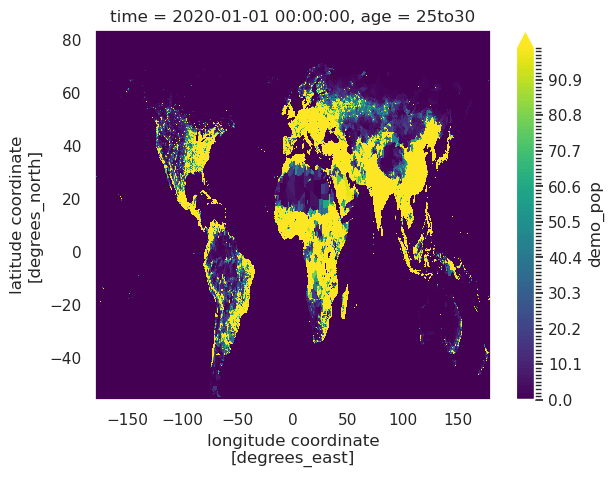

In [32]:
demographic[0].plot(levels  = np.linspace(0,100,100))

In [33]:
#get country mask
lon = population['lon']
lat = population['lat']
print(lat.shape)
mask = regionmask.mask_3D_geopandas(gdf,lon,lat)

(1117,)


In [34]:
age_theta = {
    '25to29': 0.1585,
    '30to34': 0.1577,
    '35to39': 0.1570,
    '40to44': 0.1558,
    '45to49': 0.1532,
    '50to54': 0.1499,
    '55to59': 0.1462,
    '60to64': 0.1421,
    '65to69': 0.1374,
    '70to74': 0.1319,
    '75to79': 0.1253,
    '80to84': 0.1141
}

In [37]:
mortality['time'] = AF['time'].values

### Calculating health impacts associated with air pollution (PM2.5)

Calculate mortalities attributed to PM2.5 from noncommunicable diseases and lower respiratory infections (combined) based on epidemiological cohort studies of long-term exposure to PM2.5

\begin{equation}
M = BMR \times P \times AF
\end{equation}

- M = mortality due to PM2.5
- BMR = baseline mortality rate
- P = exposed population
- AF = attributable factor

In [78]:
#AF = xr.open_mfdataset('/glade/derecho/scratch/cindywang625/RR/003.nc')['RR_base']-xr.open_mfdataset('/glade/derecho/scratch/cindywang625/RR/003.nc')['RR_em']
AF = xr.open_mfdataset('/glade/derecho/scratch/cindywang625/RR/010.nc')['RR_diff']


In [79]:
deaths_1 = mortality.values*(((demographic/1e3)*AF).transpose('time', 'age', 'lat', 'lon'))

In [80]:
deaths_val = deaths_1.where(deaths_1 != 0, np.nan)


In [81]:
deaths_val.to_netcdf('/glade/derecho/scratch/cindywang625/deaths/by_grid/010.nc')
